<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Computing-overlapping-areas-per-country" data-toc-modified-id="Computing-overlapping-areas-per-country-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Computing overlapping areas per country</a></span></li><li><span><a href="#Intersection-of-all-dataframes" data-toc-modified-id="Intersection-of-all-dataframes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Intersection of all dataframes</a></span></li></ul></div>

# Functions

In [1]:
#importing functions
%run 0-[_functions]-0_methods.ipynb

In [2]:
def plot_overlapping(gdf1,gdf2,intersection,id1,value1,id2,label1,label2):
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    # Create a custom legend handler for the intersection
    class YellowBoxHandler(Patch):
        def __init__(self, color='yellow', alpha=0.5, **kwargs):
            super().__init__(color=color, alpha=alpha, **kwargs)
    
    import geopandas as gpd
    osm_id_to_plot = value1#'1232665372'
    fig, ax = plt.subplots()

    # Plot original data 
    gdf1[gdf1[id1] == osm_id_to_plot].boundary.plot(ax=ax, color='black', linewidth=1,label=label1,ls='-')
    gdf2[gdf2[id2].isin(intersection[intersection[id1] == osm_id_to_plot][id2].values)].boundary.plot(ax=ax, color='black',ls=':', linewidth=1,label=label2)

    # Plot intersection borders in red
    intersection[intersection[id1] == osm_id_to_plot].plot(ax=ax, color='yellow', linewidth=0,label='intersection',alpha=0.50)

    # Set axis labels or any other plot configurations
    ax.set_xlabel('')
    ax.set_ylabel('')

    #removing ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    legend_labels = [label1, label2, 'Intersection']

    # Create legend handles
    handles = [
        plt.Line2D([0], [0], color='black', linestyle='-', label=legend_labels[0]),
        plt.Line2D([0], [0], color='black', linestyle=':', label=legend_labels[1]),
        YellowBoxHandler(color='yellow', alpha=0.5)
    ]

    # Create the legend
    plt.legend(handles=handles, labels=legend_labels,loc='best')
    return plt


# Computing overlapping areas per country



 2024-02-09 09:01:30.924709 running BE
2024-02-09 09:01:30.924859 importing BE osm
2024-02-09 09:37:45.459095 The column area_sqm contains strings. We convert to float
2024-02-09 09:37:55.829974 The column num_vertices contains strings. We convert to float
2024-02-09 09:38:02.336268 importing BE eubucco
2024-02-09 10:31:39.082222 The column area_sqm contains strings. We convert to float
2024-02-09 10:31:47.803999 The column num_vertices contains strings. We convert to float
2024-02-09 10:31:57.172374 importing BE jrc-dbsm
2024-02-09 11:04:25.486323 The column area_sqm contains strings. We convert to float
2024-02-09 11:04:31.353632 The column num_vertices contains strings. We convert to float
2024-02-09 11:04:37.268422 importing BE microsoft
2024-02-09 11:29:13.637956 The column area_sqm contains strings. We convert to float
2024-02-09 11:29:19.425235 The column num_vertices contains strings. We convert to float
2024-02-09 11:29:23.860912 computing total area per dataset

 2024-02-09 

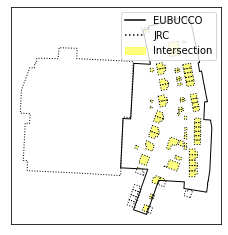

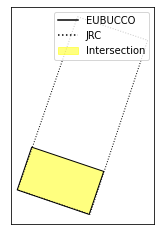

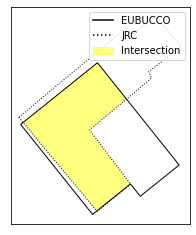

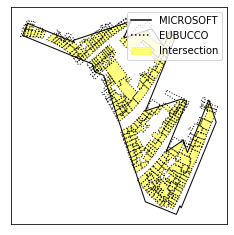

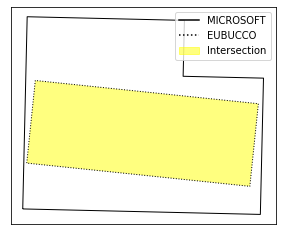

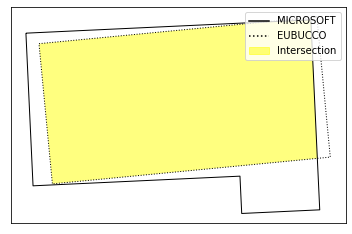

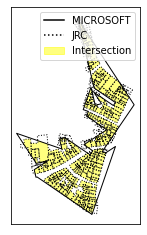

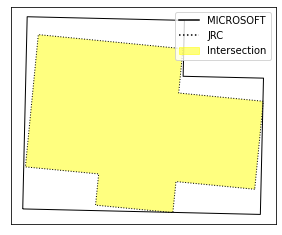

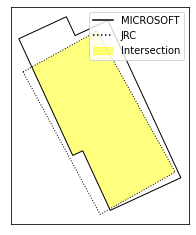

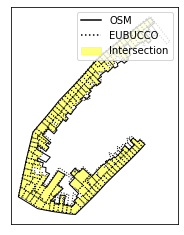

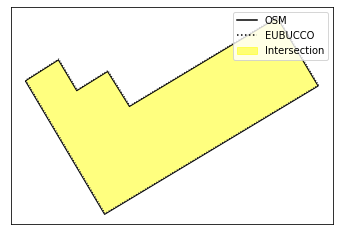

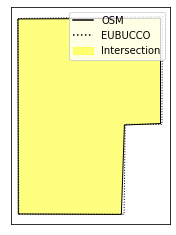

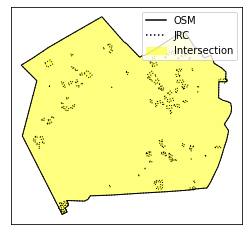

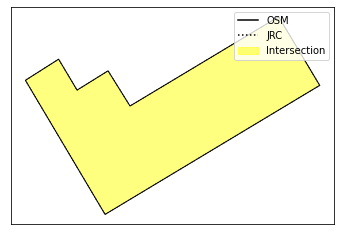

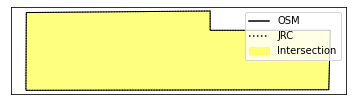

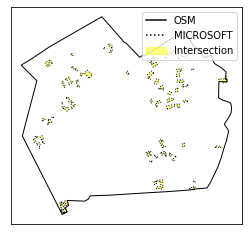

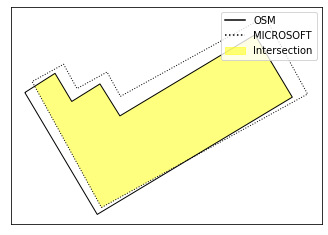

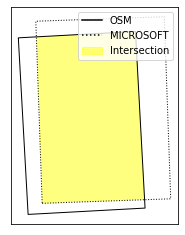

In [5]:
for country in ['BE']:

    print('\n',datetime.datetime.now(),'running',country)
    #importing data
    gdfs_osm=load_enriched_data(country,'osm')
    gdf_eubucco=load_enriched_data(country,'eubucco')
    gdf_jrc=load_enriched_data(country,'jrc-dbsm')
    gdf_microsoft=load_enriched_data(country,'microsoft')

    gdfs={'osm':gdfs_osm,'microsoft':gdf_microsoft,'eubucco':gdf_eubucco,'jrc':gdf_jrc}
    ids={key:'%s-id'%(key) for key in list(gdfs.keys())}
    
    #computing total area
    print(datetime.datetime.now(),'computing total area per dataset')
    import pandas as pd
    gdfs_osm_all_stat=pd.DataFrame(gdfs_osm.groupby(['nuts_id','urban_type'])['area_sqm'].sum()).reset_index()
    gdfs_osm_all_stat.columns=['nuts_id','urban_type','total_area']
    gdfs_osm_all_stat['dataset']='osm'
    
    gdf_eubucco_all_stat=pd.DataFrame(gdf_eubucco.groupby(['nuts_id','urban_type'])['area_sqm'].sum()).reset_index()
    gdf_eubucco_all_stat.columns=['nuts_id','urban_type','total_area']
    gdf_eubucco_all_stat['dataset']='eubucco'
    
    gdf_jrc_all_stat=pd.DataFrame(gdf_jrc.groupby(['nuts_id','urban_type'])['area_sqm'].sum()).reset_index()
    gdf_jrc_all_stat.columns=['nuts_id','urban_type','total_area']
    gdf_jrc_all_stat['dataset']='jrc'
    
    gdf_microsoft_all_stat=pd.DataFrame(gdf_microsoft.groupby(['nuts_id','urban_type'])['area_sqm'].sum()).reset_index()
    gdf_microsoft_all_stat.columns=['nuts_id','urban_type','total_area']
    gdf_microsoft_all_stat['dataset']='microsoft'
    
    all_stat=pd.concat([gdfs_osm_all_stat,gdf_eubucco_all_stat,gdf_jrc_all_stat,gdf_microsoft_all_stat])
    all_stat_dict={'osm':{},'jrc':{},'eubucco':{},'microsoft':{}}
    for row in all_stat.values:
        all_stat_dict[row[-1]][(row[0],row[1])]=row[2]
        #key1=dataset key2(nuts_id,urban_type)

    #computing possible combinations of dataframe
    from itertools import combinations
    my_list = list(gdfs.keys())
    all_pairs = sorted(list(combinations(my_list, 2)))
    print('\n',datetime.datetime.now(),'running comparisons',all_pairs)

    intersection_stats=[]
    for pair in all_pairs:
        #adding nuts layer
        import geopandas as gpd
        import datetime
        print('\n',datetime.datetime.now(),'computing intersection between %s and %s' %(pair[0],pair[1]))
        intersection = gpd.overlay(gdfs[pair[0]], gdfs[pair[1]], how='intersection')
        print(datetime.datetime.now(),'%s cardinality' %(pair[0]),len(gdfs[pair[0]]),', %s cardinality' %(pair[1]),len(gdfs[pair[1]]),', intersection cardinality',len(intersection))
        print(datetime.datetime.now(),'computing shared area in sqm')
        intersection['shared_area']=intersection['geometry'].to_crs({'init': 'epsg:3857'}).map(lambda p: p.area )

        #select 3 cases to be plotted
        plot_stat=intersection.groupby(ids[pair[0]])[ids[pair[1]]].count().reset_index().sort_values(ascending=False,by=ids[pair[1]]).reset_index()
        del(plot_stat['index'])
        c=1
        country=intersection['country_1'].unique()[0]
        for idx in [0,-1,int(len(plot_stat)/2)]:
            value0=plot_stat.values[idx][0]
            gdf1=gdfs[pair[0]]
            gdf2=gdfs[pair[1]]
            plt=plot_overlapping(gdf1,gdf2,intersection,ids[pair[0]],value0,ids[pair[1]],pair[0].upper(),pair[1].upper())
            output_file_png='%s_%s_%s_example_%s.png' %(country,pair[0].upper(),pair[1].upper(),c)
            plt.savefig('/mnt/CAS/20240101_foss4g/plots/overlapping/%s'%(output_file_png),dpi=300)
            c+=1
            
        #aggregate statistics at nuts3 level
        intersection_stat=intersection.groupby(['country_1','nuts_id_1','urban_type_1'])['area_sqm_1','area_sqm_2','shared_area'].sum().reset_index()
        intersection_stat = intersection_stat.rename(columns={'area_sqm_1': 'building_area_1'})
        intersection_stat = intersection_stat.rename(columns={'area_sqm_2': 'building_area_2'})
        intersection_stat = intersection_stat.rename(columns={'country_1': 'country'})
        intersection_stat = intersection_stat.rename(columns={'nuts_id_1': 'nuts_id'})
        intersection_stat = intersection_stat.rename(columns={'urban_type_1': 'urban_type'})
        intersection_stat['from']=pair[0]
        intersection_stat['to']=pair[1]
        
        #adding total area per dataset
        intersection_stat['total_area_1']=intersection_stat[['from','nuts_id','urban_type']].apply(lambda x:all_stat_dict[x[0]][(x[1],x[2])],axis=1)
        intersection_stat['total_area_2']=intersection_stat[['to','nuts_id','urban_type']].apply(lambda x:all_stat_dict[x[0]][(x[1],x[2])],axis=1)

        intersection_stats.append(intersection_stat)

        #saving raw intersection without geometry to compute further statistics
        del(intersection['geometry'])
        intersection.to_csv('/mnt/CAS/20240101_foss4g/datasets/out/shared_area_raw/%s/%s_%s.csv.zip' %(country,pair[0],pair[1]),compression='zip',index=False)
        intersection=None
    
        
        
    intersection_stats=pd.concat(intersection_stats)
    intersection_stats['country']=country
    intersection_stats.to_excel('/mnt/CAS/20240101_foss4g/datasets/out/shared_area_raw/%s/area_overlapped.xlsx' %(country),index=False)
    gdfs_osm=None
    gdf_eubucco=None
    gdf_jrc=None
    gdf_microsoft=None
    gdfs=None

# Intersection of all dataframes


In [3]:
import geopandas as gpd
countries=['BE']
for country in countries:
    print('\n',datetime.datetime.now(),'running',country)
    #importing data
    gdfs_osm=load_enriched_data_dask(country,'osm')
    gdf_eubucco=load_enriched_data_dask(country,'eubucco')
    gdf_jrc=load_enriched_data_dask(country,'jrc-dbsm')
    gdf_microsoft=load_enriched_data_dask(country,'microsoft')

    #computing total area
    print(datetime.datetime.now(),'computing total area per dataset')
    import pandas as pd
    gdfs_osm_all_stat=pd.DataFrame(gdfs_osm.groupby(['nuts_id','urban_type'])['area_sqm'].sum()).reset_index()
    gdfs_osm_all_stat.columns=['nuts_id','urban_type','total_area']
    gdfs_osm_all_stat['dataset']='osm'
    
    gdf_eubucco_all_stat=pd.DataFrame(gdf_eubucco.groupby(['nuts_id','urban_type'])['area_sqm'].sum()).reset_index()
    gdf_eubucco_all_stat.columns=['nuts_id','urban_type','total_area']
    gdf_eubucco_all_stat['dataset']='eubucco'
    
    gdf_jrc_all_stat=pd.DataFrame(gdf_jrc.groupby(['nuts_id','urban_type'])['area_sqm'].sum()).reset_index()
    gdf_jrc_all_stat.columns=['nuts_id','urban_type','total_area']
    gdf_jrc_all_stat['dataset']='jrc'
    
    gdf_microsoft_all_stat=pd.DataFrame(gdf_microsoft.groupby(['nuts_id','urban_type'])['area_sqm'].sum()).reset_index()
    gdf_microsoft_all_stat.columns=['nuts_id','urban_type','total_area']
    gdf_microsoft_all_stat['dataset']='microsoft'
    
    all_stat=pd.concat([gdfs_osm_all_stat,gdf_eubucco_all_stat,gdf_jrc_all_stat,gdf_microsoft_all_stat])
    all_stat_dict={'osm':{},'jrc':{},'eubucco':{},'microsoft':{}}
    for row in all_stat.values:
        all_stat_dict[row[-1]][(row[0],row[1])]=row[2]
        #key1=dataset key2(nuts_id,urban_type)
        
    gdfs={'osm':gdfs_osm,'microsoft':gdf_microsoft,'eubucco':gdf_eubucco,'jrc':gdf_jrc}
    gdfs_osm,gdf_eubucco,gdf_jrc,gdf_microsoft=None,None,None,None
    
    for key in list(gdfs.keys()):
        print (datetime.datetime.now(),'renaming columns for',key)
        for col in list(gdfs[key].columns):
            if col in ['source', 'dataset', 'country', 'area_sqm', 'num_vertices', 'nuts_id', 'urban_type', 'nuts_name']:
                gdfs[key] = gdfs[key].rename(columns={col: '%s_%s'%(col,key)})

    print(datetime.datetime.now(),'processing intersection between osm (#rows:%s) and eubucco (#rows:%s)' %(len(gdfs['osm']),len(gdfs['eubucco'])))
    intersection = gpd.overlay(gdfs['osm'][['osm-id','country_osm','nuts_id_osm','urban_type_osm','area_sqm_osm','geometry']], gdfs['eubucco'][['eubucco-id','area_sqm_eubucco','geometry']], how='intersection')
    print(datetime.datetime.now(),'resulting intersection (#rows:%s) with microsoft (#rows:%s)' %(len(intersection),len(gdfs['microsoft'])))
    intersection = gpd.overlay(intersection, gdfs['microsoft'][['microsoft-id','area_sqm_microsoft','geometry']], how='intersection')
    print(datetime.datetime.now(),'resulting intersection (#rows:%s) with jrc (#rows:%s)' %(len(intersection),len(gdfs['jrc'])))
    intersection = gpd.overlay(intersection, gdfs['jrc'][['jrc-id','area_sqm_jrc','geometry']], how='intersection')
    print(datetime.datetime.now(),'final results (#rows:%s) ' %(len(intersection)))
    print(datetime.datetime.now(),'computing shared area in sqm')
    intersection['shared_area']=intersection['geometry'].to_crs({'init': 'epsg:3857'}).map(lambda p: p.area )
    print(datetime.datetime.now(),'computing final statistics')
    #aggregate statistics at nuts3 level
    intersection_stat=intersection.groupby(['country_osm','nuts_id_osm','urban_type_osm'])['area_sqm_osm','area_sqm_eubucco','area_sqm_jrc','area_sqm_microsoft','shared_area'].sum().reset_index()

    #adding total area per dataset
    intersection_stat['total_area_osm']=intersection_stat[['nuts_id_osm','urban_type_osm']].apply(lambda x:all_stat_dict['osm'][(x[0],x[1])],axis=1)
    intersection_stat['total_area_microsoft']=intersection_stat[['nuts_id_osm','urban_type_osm']].apply(lambda x:all_stat_dict['microsoft'][(x[0],x[1])],axis=1)
    intersection_stat['total_area_jrc']=intersection_stat[['nuts_id_osm','urban_type_osm']].apply(lambda x:all_stat_dict['jrc'][(x[0],x[1])],axis=1)
    intersection_stat['total_area_eubucco']=intersection_stat[['nuts_id_osm','urban_type_osm']].apply(lambda x:all_stat_dict['eubucco'][(x[0],x[1])],axis=1)
    intersection_stat.to_excel('/mnt/CAS/20240101_foss4g/datasets/out/shared_area_raw/%s/area_overlapped_intersection_all.xlsx' %(country),index=False)

    #saving raw intersection without geometry to compute further statistics
    del(intersection['geometry'])
    print(datetime.datetime.now(),'exporting raw intersection')
    intersection.to_csv('/mnt/CAS/20240101_foss4g/datasets/out/shared_area_raw/%s/intersection_all.csv.zip' %(country))
    gdfs=None


 2024-02-09 17:56:43.255955 running BE
2024-02-09 17:57:18.786120 importing BE osm
2024-02-09 18:00:15.057869 The column area_sqm contains strings. We convert to float
2024-02-09 18:00:20.470854 The column num_vertices contains strings. We convert to float
2024-02-09 18:00:25.981976 importing BE eubucco
2024-02-09 18:05:15.400870 The column area_sqm contains strings. We convert to float
2024-02-09 18:05:22.442095 The column num_vertices contains strings. We convert to float
2024-02-09 18:05:30.307299 importing BE jrc-dbsm
2024-02-09 18:07:52.994959 The column area_sqm contains strings. We convert to float
2024-02-09 18:07:57.501681 The column num_vertices contains strings. We convert to float
2024-02-09 18:08:02.516169 importing BE microsoft
2024-02-09 18:09:48.581761 The column area_sqm contains strings. We convert to float
2024-02-09 18:09:52.755197 The column num_vertices contains strings. We convert to float
2024-02-09 18:09:56.255399 computing total area per dataset
2024-02-09 18